# *Ambrosia* data preprocessing tools overview

This example describes the data preprocessing methods which are implemented in the library. For the demonstration of these tools usage, synthetically generated one week data of daily content views by users is used.

Data processing tools are the number of classes that have the same access interface - they have set of implemented methods that are intuitive to the users:

``fit`` - get the necessary for class parameters from the passed data \
``transform`` - make transformation of the passed data \
``fit_transform`` - combine the above two methods \
``get_params_dict`` - get a dict of fitted params \
``load_params_dict`` - set a dict of pre-fitted params \
``store_params`` - store fitted params to a file \
``load_params `` - load pre-fitted params from a file

Let's take a look on some of preprocessing classes in the context of processing our user dataset.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from ambrosia.preprocessing import (AggregatePreprocessor, RobustPreprocessor,
                                    IQRPreprocessor, LogTransformer,
                                    BoxCoxTransformer)

Load data

In [3]:
data = pd.read_csv('../tests/test_data/week_metrics.csv')

In [4]:
data.head()

,id,gender,watched,sessions,day,platform
0,0,Male,28.440846,4,1,android
1,1,Female,1.825271,2,1,ios
2,2,Female,46.995606,0,1,web
3,3,Female,37.310264,1,1,ios
4,4,Female,147.513105,0,1,web


## Data aggregation

In our task, we would like to first aggregate data by user in order, for example, to get a more reliable statistical picture of the views metric and get rid of intra-user the dependency.

For this we will use the ``AggregatePreprocessor`` class, which allows us to aggregate categorical and continuous variables in a convenient way.

The default aggregation behavior is set at instantiation time. However, when aggregating, we can always use the more detailed ``agg_params`` parameter, which sets own aggregation method for each metric.

In [5]:
aggregator = AggregatePreprocessor(categorial_method='mode', real_method='sum')

Now fit aggregator and transform the data 

In [6]:
aggregator.fit_transform(dataframe=data,
                         groupby_columns='id',
                         real_cols=['watched', 'sessions'],
                         categorial_cols=['gender', 'platform'])

,id,watched,sessions,gender,platform
0,0,772.597224,8,Male,ios
1,1,538.076739,15,Female,android
2,2,288.492353,20,Female,android
3,3,373.620408,9,Female,ios
4,4,630.238862,14,Female,ios
...,...,...,...,...,...
4995,4995,390.133588,14,Male,android
4996,4996,544.423724,25,Female,ios
4997,4997,204.713032,19,Male,android
4998,4998,1088.642872,25,Female,web


The instance is fitted now and we can see its parameters

In [7]:
aggregator.get_params_dict()

{'aggregation_params': {'watched': 'sum',
  'sessions': 'sum',
  'gender': 'mode',
  'platform': 'mode'},
 'groupby_columns': 'id'}

These parameters can be saved as a json file and loaded in the future for the same aggregation tasks. But first let's refit the aggregator using detailed aggregation. You can use aliases for aggregation or pass pandas compatible methods.

In [8]:
# Add extra column before
data['is_holiday'] = data['day'].apply(lambda x: 0 if x < 6 else 1)

In [9]:
aggregator.fit_transform(
    data,
    groupby_columns=['id', 'is_holiday'],
    agg_params={
        'watched': 'sum',
        'sessions': 'max',
        'gender': 'simple',  # simple - choose the first possible value
        'platform': 'mode'
    })

,id,is_holiday,watched,sessions,gender,platform
0,0,0,601.893096,4,Male,ios
1,0,1,170.704127,1,Male,android
2,1,0,327.533247,3,Female,web
3,1,1,210.543492,6,Female,ios
4,2,0,271.548875,7,Female,web
...,...,...,...,...,...,...
9995,4997,1,65.368574,2,Male,ios
9996,4998,0,1051.360035,4,Female,web
9997,4998,1,37.282837,10,Female,android
9998,4999,0,245.553217,6,Male,android


Check and store instance parameters in a file

In [10]:
aggregator.get_params_dict()

{'aggregation_params': {'watched': 'sum',
  'sessions': 'max',
  'gender': 'simple',
  'platform': 'mode'},
 'groupby_columns': ['id', 'is_holiday']}

In [11]:
aggregator.store_params('_examples_configs/aggregator.json')

Create new instance

In [12]:
aggregator_loaded = AggregatePreprocessor()

Load parameters

In [13]:
aggregator_loaded.load_params('_examples_configs/aggregator.json')

In [14]:
aggregator_loaded.get_params_dict()

{'aggregation_params': {'watched': 'sum',
  'sessions': 'max',
  'gender': 'simple',
  'platform': 'mode'},
 'groupby_columns': ['id', 'is_holiday']}

Aggregate data

In [15]:
data_aggregated = aggregator_loaded.transform(data)

In [16]:
data_aggregated.head()

,id,is_holiday,watched,sessions,gender,platform
0,0,0,601.893096,4,Male,ios
1,0,1,170.704127,1,Male,android
2,1,0,327.533247,3,Female,web
3,1,1,210.543492,6,Female,ios
4,2,0,271.548875,7,Female,web


---

## Cleaning the outliers

In many problems, we need to get rid of outliers in the data in order to make the results more reliable and applied statistical tests more sensitive. 

For this purpose, the library contains 2 classes: ``RobustPreprocessor`` and ``IQRPreprocessor``. \
We will remove some rows from our aggregated data using these techniques.

---

### ``RobustPreprocessor``

The ``RobustPreprocessor`` removes objects that fall into the tails of the empirical distribution of the metrics that is estimaed form the passed data. The type of tail and its size for threshold calculation is specified by the user during fitting the data.

Let's create an instance

In [17]:
robust_transformer = RobustPreprocessor()

Fit transformer

In [18]:
robust_transformer.fit(dataframe=data_aggregated,
                       column_names='watched',
                       alpha=0.01,
                       tail='right')

Check fitted params

In [19]:
robust_transformer.get_params_dict()

{'tail': 'right',
 'column_names': ['watched'],
 'alpha': [0.01],
 'quantiles': [[1049.5734329308516]]}

Transform data (1% of rows will be removed, because this is the same dataframe)

In [20]:
robust_transformer.transform(data_aggregated)

ambrosia LOGGER: Making right-tail robust transformation of columns ['watched']
                 with alphas = [0.01]
ambrosia LOGGER: 

ambrosia LOGGER: Change Mean watched: 350.8333 ===> 342.2530
ambrosia LOGGER: Change Variance watched: 56929.6826 ===> 49971.0812
ambrosia LOGGER: Change IQR watched: 331.3509 ===> 325.2846
ambrosia LOGGER: Change Range watched: 1566.7685 ===> 1047.1196


,id,is_holiday,watched,sessions,gender,platform
0,0,0,601.893096,4,Male,ios
1,0,1,170.704127,1,Male,android
2,1,0,327.533247,3,Female,web
3,1,1,210.543492,6,Female,ios
4,2,0,271.548875,7,Female,web
...,...,...,...,...,...,...
9994,4997,0,139.344458,6,Male,android
9995,4997,1,65.368574,2,Male,ios
9997,4998,1,37.282837,10,Female,android
9998,4999,0,245.553217,6,Male,android


For all our preprocessing classes we have same methods for storing and loading parameters. This is useful to process the data in the future in the same way.

In [21]:
robust_transformer.store_params('_examples_configs/robust.json')

Recreate instance

In [22]:
del robust_transformer

robust_transformer = RobustPreprocessor()

Load params

In [23]:
robust_transformer.load_params('_examples_configs/robust.json')

Transform data (we get the same transformation as before)

In [24]:
robust_transformer.transform(data_aggregated)

ambrosia LOGGER: Making right-tail robust transformation of columns ['watched']
                 with alphas = [0.01]
ambrosia LOGGER: 

ambrosia LOGGER: Change Mean watched: 350.8333 ===> 342.2530
ambrosia LOGGER: Change Variance watched: 56929.6826 ===> 49971.0812
ambrosia LOGGER: Change IQR watched: 331.3509 ===> 325.2846
ambrosia LOGGER: Change Range watched: 1566.7685 ===> 1047.1196


,id,is_holiday,watched,sessions,gender,platform
0,0,0,601.893096,4,Male,ios
1,0,1,170.704127,1,Male,android
2,1,0,327.533247,3,Female,web
3,1,1,210.543492,6,Female,ios
4,2,0,271.548875,7,Female,web
...,...,...,...,...,...,...
9994,4997,0,139.344458,6,Male,android
9995,4997,1,65.368574,2,Male,ios
9997,4998,1,37.282837,10,Female,android
9998,4999,0,245.553217,6,Male,android


The dispersion characteristics of the data have decreased.

---

### ``IQRPreprocessor``

The ``IQRPreprocessor`` class removes objects that go beyond the maximum and minimum values of the constructed boxplot based on the passed data with empirical distribution of the metrics.

Again create an instance

In [25]:
iqr_transformer = IQRPreprocessor()

Fit (this time we will use two metrics)

In [26]:
iqr_transformer.fit(dataframe=data_aggregated,
                    column_names=['watched', 'sessions'])

Look at fitted params

In [27]:
iqr_transformer.get_params_dict()

{'column_names': ['watched', 'sessions'],
 'medians': [304.98240670946467, 4.0],
 'quartiles': [[161.81242236582537, 493.1633345302498], [2.0, 7.0]]}

Transform data

In [28]:
data_aggregated = iqr_transformer.transform(data_aggregated)

ambrosia LOGGER: Making IQR transformation of columns ['watched', 'sessions']
ambrosia LOGGER: 

ambrosia LOGGER: Change Mean watched: 350.8333 ===> 338.0876
ambrosia LOGGER: Change Variance watched: 56929.6826 ===> 47660.8027
ambrosia LOGGER: Change IQR watched: 331.3509 ===> 321.3204
ambrosia LOGGER: Change Range watched: 1566.7685 ===> 987.6670
ambrosia LOGGER: 

ambrosia LOGGER: Change Mean sessions: 4.8478 ===> 4.5908
ambrosia LOGGER: Change Variance sessions: 12.5680 ===> 9.5394
ambrosia LOGGER: Change IQR sessions: 5.0000 ===> 4.0000
ambrosia LOGGER: Change Range sessions: 30.0000 ===> 14.0000


Check how many rows have been removed

In [29]:
data_aggregated.shape

(9662, 6)

Class instance parameters can be stored and loaded from a file as well as for other classes.

---

## Metric tranformations

For some tasks, we may want to transform metrics, for example, to reduce the variance or make distribution shape more normal (however, be careful with this procedure, as you may lose the interpretability of the metrics).

For that purpose, we have implemented two common transformers: ``LogTransformer``, ``BoxCoxTransformer``. \
We will demonstrate their work on our ``watched`` data.

---

### ``LogTransformer``

This transformer simply applied a logarithmic transformation to the metrics. Since it has the same interface as other classes, we still need to fit it to the data and it will fit only the names of the columns.

Create an instance

In [30]:
log_transformer = LogTransformer()

Fit transformer

In [31]:
log_transformer.fit(dataframe=data_aggregated, column_names=['watched'])

Transform data

In [32]:
data_aggregated_logged = log_transformer.transform(data_aggregated)

Make sure that the variance of the metric has decreased after the transformation

In [33]:
print('Original std:', data_aggregated.watched.std())
print('Log metric std:', data_aggregated_logged.watched.std())

Original std: 218.32484049843603
Log metric std: 0.827898247795576


Class instance parameters can be stored and loaded from a file.

---

### ``BoxCoxTransformer``

This class uses the Box-Cox transformation from the power transformation family and allows to make the data distribution more normal. \
The ``lambda_`` power parameter of the transformation is selected automatically during fitting.

Create an instance

In [34]:
boxcox_transformer = BoxCoxTransformer()

Fit transformer

In [35]:
boxcox_transformer.fit(dataframe=data_aggregated, column_names=['watched'])

Transform data

In [36]:
boxcox_transformer.transform(data_aggregated)

,id,is_holiday,watched,sessions,gender,platform
0,0,0,34.356077,4,Male,ios
1,0,1,18.974271,1,Male,android
2,1,0,25.887571,3,Female,web
3,1,1,20.991262,6,Female,ios
4,2,0,23.696137,7,Female,web
...,...,...,...,...,...,...
9994,4997,0,17.188778,6,Male,android
9995,4997,1,11.753853,2,Male,ios
9997,4998,1,8.726168,10,Female,android
9998,4999,0,22.590802,6,Male,android


Check fitted parameters

In [37]:
boxcox_transformer.get_params_dict()

{'column_names': ['watched'], 'lambda_': [0.4314844480895849]}

Store them in a file

In [38]:
boxcox_transformer.store_params('_examples_configs/boxcox_tranformer.json')

Create new instance

In [39]:
boxcox_transformer_loaded = BoxCoxTransformer()

Load params

In [40]:
boxcox_transformer_loaded.load_params(
    '_examples_configs/boxcox_tranformer.json')

Transform metric and compare distribution shape with the unchanged one

<AxesSubplot:xlabel='watched', ylabel='Count'>

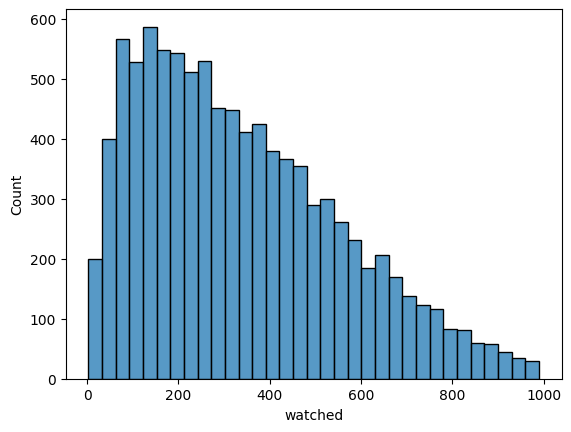

In [41]:
sns.histplot(data_aggregated.watched)

<AxesSubplot:xlabel='watched', ylabel='Count'>

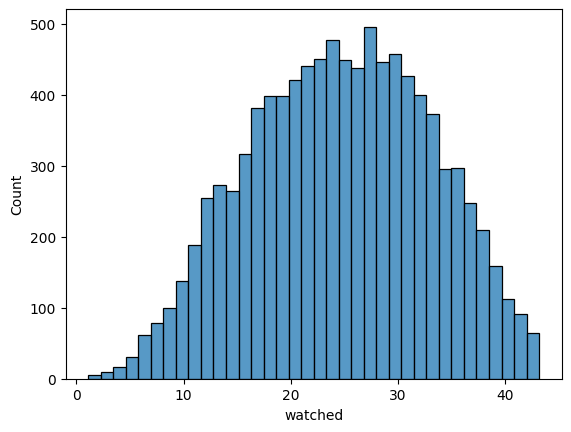

In [42]:
sns.histplot(boxcox_transformer_loaded.transform(data_aggregated).watched)

Metric distribution becomes more normal

---

*One note*: for convenience, all transformers can apply their transformation directly to the passed dataframe, just set the ``inplace`` parameter to ``True`` in the corresponding transformation method.

---

*Ambrosia* preprocessing functionality is not limited to these classes

Check:

* An overview of advanced metric transformation to learn about different methods for reducing variance
* An overview of the ``Preprocessor`` class - a convenient chain pipeline transformer that combines almost all      available preprocessing techniques in its methods
* *Ambrosia* preprocessing modules documentation